# Setup

## Imports

In [82]:
import pandas as pd
import numpy as np
from fastai.tabular.all import *
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score


## Checking the platform and downloadint the files if needed

In [83]:
try:
    import google.colab
    print("Running in Google Colab")
    COLAB = True
except ImportError:
    print("Not running in Google Colab")
    COLAB = False

required_files = [
    'data/RD0105ACDISDeaths.dta',
    'data/verbal_autopsy.dta',
    'data/VerbalAutopsy_extracted_table.csv'
]

files_present = all([os.path.isfile(file) for file in required_files])

if files_present:
    print('Files already present')
else:
    os.makedirs('data', exist_ok=True)
    !git clone https://github.com/carlvh-wimmy/ahri_practicals
    !mv ahri_practicals/verbal_autopsy_nn/data/RD0105ACDISDeaths.dta data/
    !mv ahri_practicals/verbal_autopsy_nn/data/verbal_autopsy.dta data/
    !mv ahri_practicals/verbal_autopsy_nn/data/VerbalAutopsy_extracted_table.csv data/

Not running in Google Colab
Files already present


## Reading in the data

We start by reading in all the data. The data is in the form of Stata .dta files so we read that in. Additionally I've read in a pdf explaining how the codes relate to questions asked in the verbal autopsy in to a dataframe *questions_df* so we can see what the questions asked are.

In [84]:
deaths_df = pd.read_stata('data/RD0105ACDISDeaths.dta')
deaths_df.rename(columns={'IIntId': 'ID'}, inplace=True)
verbal_autopsy_df = pd.read_stata('data/verbal_autopsy.dta')
verbal_autopsy_df.rename(columns={'iv5_id': 'ID'}, inplace=True)
questions_df = pd.read_csv('data/VerbalAutopsy_extracted_table.csv')
questions_df = questions_df[~questions_df['Code'].str.contains("Verbal", na=False)]

# Merging the verbal autopsy answers with the death certificates
df = pd.merge(deaths_df, verbal_autopsy_df, on='ID', how='inner')

## Defining metric functions

In [ ]:
def precision(inp, targ):
    preds = inp.argmax(dim=1)
    return precision_score(targ, preds, average='weighted', zero_division=0)

def recall(inp, targ):
    preds = inp.argmax(dim=1)
    return recall_score(targ, preds, average='weighted', zero_division=0)

In [85]:
def plot_metrics(learn):
    # Extract training loss after each batch and group by epoch
    num_batches_per_epoch = len(learn.recorder.losses) // len(learn.recorder.values)
    train_loss_per_epoch = [np.mean(learn.recorder.losses[i * num_batches_per_epoch:(i + 1) * num_batches_per_epoch]).item() 
                            for i in range(len(learn.recorder.values))]

    # Extract validation loss and accuracy from learn.recorder.values
    valid_loss = [v[learn.recorder.metric_names.index('valid_loss') - 1] for v in learn.recorder.values]
    accuracy = [v[learn.recorder.metric_names.index('accuracy') - 1] for v in learn.recorder.values]

    # Create a plot for training loss, validation loss, and accuracy
    epochs = range(len(valid_loss))  # valid_loss and accuracy are calculated per epoch, so use this range

    plt.figure(figsize=(10, 6))

    # Plot averaged training loss per epoch
    plt.plot(epochs, train_loss_per_epoch, label='Training Loss', alpha=0.6)

    # Plot validation loss
    plt.plot(epochs, valid_loss, label='Validation Loss')

    # Plot accuracy
    plt.plot(epochs, accuracy, label='Accuracy')

    # Add labels and legend
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.title('Training/Validation Loss and Accuracy over Epochs')
    plt.legend()

    plt.show()


# plot_metrics(learn)

In [109]:
def plot_metrics_plus_precrec(learn):
    # Calculate the average training loss per epoch
    num_batches_per_epoch = len(learn.recorder.losses) // len(learn.recorder.values)
    train_loss_per_epoch = [np.mean(learn.recorder.losses[i * num_batches_per_epoch:(i + 1) * num_batches_per_epoch]).item() 
                            for i in range(len(learn.recorder.values))]

    # Extract validation loss, accuracy, precision, and recall from learn.recorder.values
    valid_loss = [v[learn.recorder.metric_names.index('valid_loss') - 1] for v in learn.recorder.values]
    accuracy = [v[learn.recorder.metric_names.index('accuracy') - 1] for v in learn.recorder.values]
    precision = [v[learn.recorder.metric_names.index('precision') - 1] for v in learn.recorder.values]
    recall = [v[learn.recorder.metric_names.index('recall') - 1] for v in learn.recorder.values]

    # Create the first plot for training and validation loss
    epochs = range(len(valid_loss))  # valid_loss is calculated per epoch

    plt.figure(figsize=(12, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)  # First subplot (1 row, 2 columns, 1st plot)
    plt.plot(epochs, train_loss_per_epoch, label='Training Loss', alpha=0.6)
    plt.plot(epochs, valid_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, precision, label='Precision', color='green', marker='o')
    plt.plot(epochs, recall, label='Recall', color='red', marker='s')
    plt.plot(epochs, accuracy, label='Accuracy', color='blue', marker='^')
    
    
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.title('Accuracy, Precision, and Recall over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

# plot_metrics_plus_precrec(learn)

## Inspecting the data

In [88]:
deaths_df.head().T

,0,1,2,3,4
ID,11,12,16,19,20
DateOfDeath,2004-12-12 00:00:00,2006-02-01 00:00:00,2013-01-18 00:00:00,2015-10-14 00:00:00,2005-11-05 00:00:00
IEndInformantId,NaN,42.0,25.0,34.0,16.0
IEndInformantType,_other,Caregiver,Household Member,Household Member,Household Member
DateOfBirth,1945-01-10 00:00:00,1940-12-26 00:00:00,1952-11-16 00:00:00,1939-08-18 00:00:00,1973-06-25 00:00:00
Sex,Male,Female,Female,Female,Female
DeathNotificationDate,2005-04-28 00:00:00,2006-08-02 00:00:00,2013-02-19 00:00:00,2015-11-17 00:00:00,2007-03-26 00:00:00
VisitType,Regular Visit,Unsuccessful Visit,Regular Visit,Regular Visit,Regular Visit
DeathSetting,_don't know,Own Home,Own Home,Own Home,Governmental (public) Hospital
DeathCareProvider,_don't know,Family Member,Family Member,Family Member,_don't know


In [89]:
verbal_autopsy_df.head().T

,0,1,2,3,4
ID,11,12,16,19,20
DoB,1945-01-10 00:00:00,1940-12-26 00:00:00,1952-11-16 00:00:00,1939-08-18 00:00:00,1973-06-25 00:00:00
DoD,2004-12-12 00:00:00,2006-02-01 00:00:00,2013-01-18 00:00:00,2015-10-14 00:00:00,2005-11-05 00:00:00
InterviewDate,2006-02-06 00:00:00,2007-10-10 00:00:00,2013-09-10 00:00:00,2016-02-09 00:00:00,2007-08-27 00:00:00
DeathSetting,Other,Home,Home,Home,Hospital
...,...,...,...,...,...
i455o,No,No,No,No,No
i456o,NaN,NaN,NaN,NaN,NaN
i457o,No,No,No,No,Yes
i458o,NaN,NaN,NaN,NaN,NaN


In [90]:
questions_df.head(10)

,Nr,Code,Label,Type,Format,Valid,Invalid,Question
1,2,DoB,Date of Birth,discrete,character-11,2283,7,-
2,3,DoD,Date of Death,discrete,character-11,2283,7,-
3,4,Intervie,.. Interview Date,discrete,character-11,2282,7,-
4,5,DeathSet,.. Place of death,discrete,numeric-12.0,21385,1452,-
5,6,sv_refer,.. Was the child referred to another place for care?,discrete,numeric-12.0,72,22765,-
6,7,sv_reach,.. Did they reach the place they were referred to?,discrete,numeric-12.0,22,22815,-
7,8,sb_minut,.. How many minutes after birth did the baby first cry?,continuous,numeric-12.0,23,22814,-
8,9,ap_menta,.. For how many months did (s)he have mental confusion?,continuous,numeric-12.0,558,22279,-
9,10,md_preg_,.. Was she pregnant at the time of death?,discrete,numeric-12.0,1514,21323,-
10,11,md_die_d,".. Did she die within 6 weeks of delivery, abortion or miscarriage?",discrete,numeric-12.0,1505,21332,-


We want to look at the Global Burden of Disease group (DeathCauseGBDgroup). There are a number of entries with "unknown entered" as their group and we want to try and predict those.

In [91]:
df['DeathCauseGBDgroup'].value_counts(dropna=False)

DeathCauseGBDgroup
AIDS_TB     7582
Unknown     7217
NonComm     3363
CMPN        2023
Injuries    1507
Name: count, dtype: int64

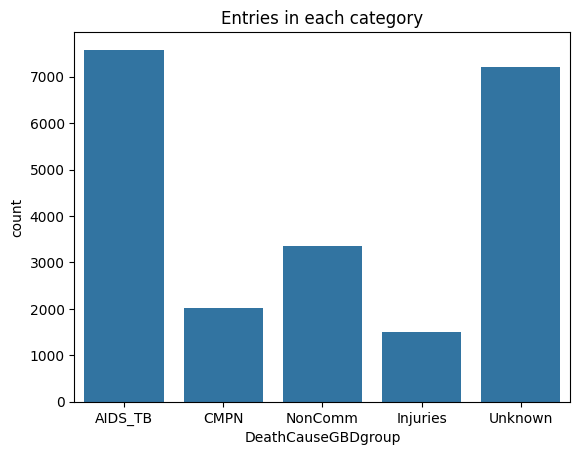

In [92]:
plt.figure()
plt.title('Entries in each category')
sns.countplot(x= df['DeathCauseGBDgroup'],)
plt.show()

## Preparing the data

Now we prepare which variables will be used in training the model. We calculate age, as this would likely be important in predicting the cause of death. We use all the questions of the verbal autopsy. And we don't use columns like ID, Date of Birth and Interview Date in training the model. va_cont are the continous variables - here just age. va_cat are all the categorical variables - in this case teh questions answered.

In [93]:
df['Age'] = (df['DateOfDeath'] - df['DateOfBirth']).dt.days / 365.25
va_cont = ['Age']
va_cat = list(verbal_autopsy_df.columns)
items_to_remove = ['ID', 'DoB', 'DoD', 'InterviewDate', 'DeathSetting']  
va_cat = [item for item in va_cat if item not in items_to_remove]

In [94]:
va_cat

['sv_referralanother',
 'sv_reachplace',
 'i004a',
 'i004b',
 'i019a',
 'i019b',
 'i022a',
 'i022b',
 'i022c',
 'i022d',
 'i022e',
 'i022f',
 'i022g',
 'i022h',
 'i022i',
 'i022j',
 'i022k',
 'i022l',
 'i022m',
 'i022n',
 'i059o',
 'i077o',
 'i079o',
 'i082o',
 'i083o',
 'i084o',
 'i085o',
 'i086o',
 'i087o',
 'i089o',
 'i090o',
 'i091o',
 'i092o',
 'i093o',
 'i094o',
 'i095o',
 'i096o',
 'i098o',
 'i099o',
 'i100o',
 'i104o',
 'i105o',
 'i106a',
 'i107o',
 'i108a',
 'i109o',
 'i110o',
 'i111o',
 'i112o',
 'i113o',
 'i114o',
 'i115o',
 'i116o',
 'i120a',
 'i120b',
 'i123o',
 'i125o',
 'i127o',
 'i128o',
 'i129o',
 'i130o',
 'i131o',
 'i132o',
 'i133o',
 'i134o',
 'i135o',
 'i136o',
 'i137o',
 'i138o',
 'i139o',
 'i140o',
 'i141o',
 'i142o',
 'i143o',
 'i144o',
 'i147o',
 'i148a',
 'i148b',
 'i148c',
 'i149o',
 'i150a',
 'i151a',
 'i152o',
 'i153o',
 'i154a',
 'i154b',
 'i155o',
 'i156o',
 'i157o',
 'i158o',
 'i159o',
 'i161a',
 'i165a',
 'i166o',
 'i167a',
 'i167b',
 'i168o',
 'i169a',

We create two dataframes, one in which we know the DeathCauseGBDgroup - we will use this for training the model, and one in which the DeathCauseGBDgroup is unknown - we will use this group to do inference to try and predict from the model we trained before.

In [95]:
df_known_gbd = df[df['DeathCauseGBDgroup'] != 'Unknown']
df_unknown_gbd = df[df['DeathCauseGBDgroup'] == 'Unknown']

In [96]:
df_unknown_gbd.head()

,ID,DateOfDeath,IEndInformantId,IEndInformantType,DateOfBirth,Sex,DeathNotificationDate,VisitType,DeathSetting_x,DeathCareProvider,...,i451o,i452o,i453o,i454o,i455o,i456o,i457o,i458o,i459o,Age
2,16,2013-01-18,25.0,Household Member,1952-11-16,Female,2013-02-19,Regular Visit,Own Home,Family Member,...,NaN,NaN,NaN,NaN,No,NaN,No,NaN,NaN,60.172485
3,19,2015-10-14,34.0,Household Member,1939-08-18,Female,2015-11-17,Regular Visit,Own Home,Family Member,...,NaN,NaN,NaN,NaN,No,NaN,No,NaN,NaN,76.156057
5,56,2013-08-03,NaN,Household Head,1953-04-16,Male,2013-11-12,Regular Visit,Governmental (public) Hospital,Nurse / Midwife,...,NaN,NaN,NaN,NaN,No,NaN,No,NaN,NaN,60.298426
12,84,2016-08-27,83.0,Household Member,1983-12-03,Male,2016-11-02,Regular Visit,Governmental (public) Hospital,Nurse / Midwife,...,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,32.733744
24,135,2018-05-18,140.0,Household Member,1965-10-23,Male,2018-06-05,Regular Visit,Private Hospital,Nurse / Midwife,...,Yes,No,No,No,No,No,No,Yes,Yes,52.566735


# Training 

In order to set up training the model, we need to tell the model what to do with the dataframe
* dep_var is the dependent variable we intend to predict, here DeathCauseGBDgroup
* procs are are preprocessing procedures we want to perform. In this case we want to prepare categorical variables, fill in missing values with special values the model can deal with and normalise continuous variables
* splits refers to holding out a validation set: After every epoch we test the accuracy of the model on a part of the dataset the model has used to update the weights. We use 20% of the data as the validation set, you can use more or less depending on how much data you have. Here it may be reasonable to use a smaller validation set as there are many data.

We feed all these variables to the TabularPandas object: this arranges the preprocessed data so it can be used in the dataloaders (in the next block of code). The dataloaders object is what feeds the data to the model when it trains.

Once we have the dataloaders object ready, we can use it to feed data to the actual model.

In [97]:
dep_var = 'DeathCauseGBDgroup'
procs = [Categorify, FillMissing, Normalize]
splits = RandomSplitter(valid_pct=0.2, seed=42)(range_of(df_known_gbd))
to = TabularPandas(df_known_gbd, procs=procs, cat_names=va_cat, cont_names=va_cont, y_names=dep_var, splits=splits)

In the next block of code we train the model. Once we have the data in a workable dataloaders, the hardest part is done and the fun begins. 

The specific machine learning model we use here is the FastAI [tabular_learner](https://docs.fast.ai/tabular.learner.html). It consists of a predefined architecture of a neural network one that has been tested to have reasonable performance "out of the box" (i.e. without having to tinker too much with the matrix sizes, shapes and hyperparameters). We will be using it in the "out of the box" mode for this tutorial, but you can change how it works, what the shapes of the tensors are, which optimiser you use, whether you use something like dropout of neurons etc by modifying the model or designing a new one from scratch.

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.477214,1.108237,0.747496,0.721440,0.747496,00:13
1,0.359955,0.364825,0.868048,0.867946,0.868048,00:08
2,0.309792,0.384391,0.864940,0.868922,0.864940,00:08


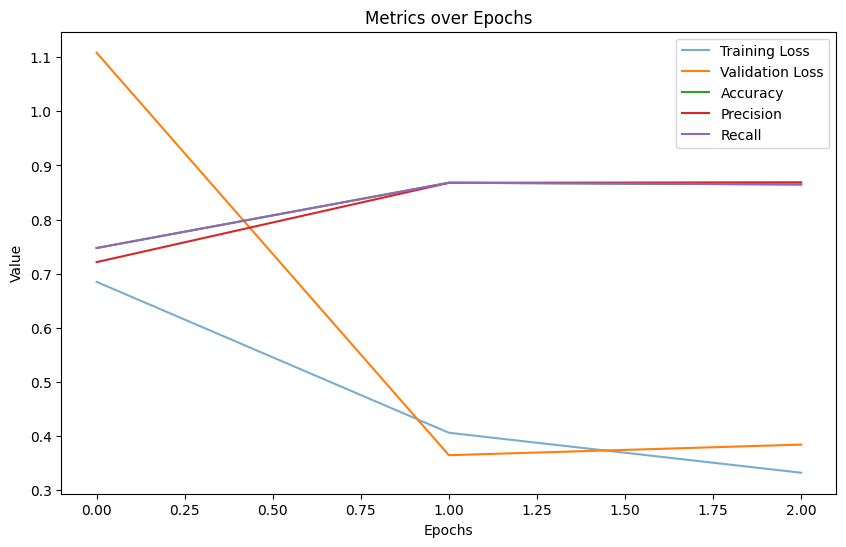

In [108]:
dls = to.dataloaders(bs=256)
learn = tabular_learner(dls, metrics=[accuracy, precision, recall])
learn.fit(3)


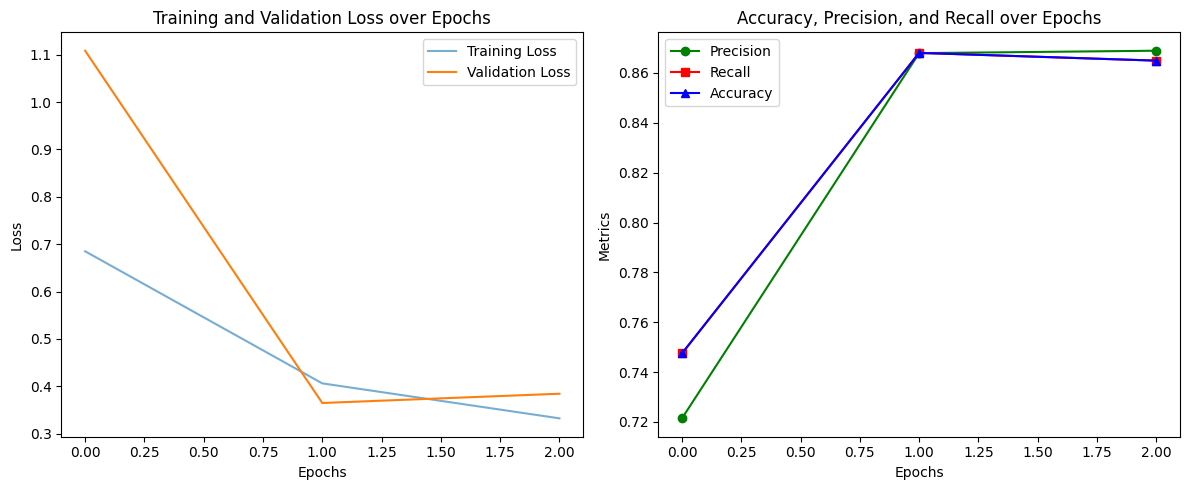

In [110]:
plot_metrics_plus_precrec(learn)

We have some basic hyperparameters at our disposal and we will look at them in more detail now:
* Batch size
* Learning rate
* Number of epochs (i.e. the number of times we train on the full training set)

## Tweaking the batch size

Batch size refers to the number of rows processed before the gradients are adjusted again. 
* Large batch sizes require more memory to process, but result in the model training quicker.
* Smaller batch sizes take longer to train but require less memory

It may happen that your system is unable to handle large batch sizes without your kernel crashing, and then lower the batch size can allow you to train your model without resorting to a more powerful system.

Changing the batch size may also result changes in performance as we'll see shortly.

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.428128,0.432538,0.848014,0.871920,0.848014,00:50
1,0.368275,0.400009,0.855268,0.874394,0.855268,00:56
2,0.325524,1.688148,0.841105,0.861250,0.841105,00:50


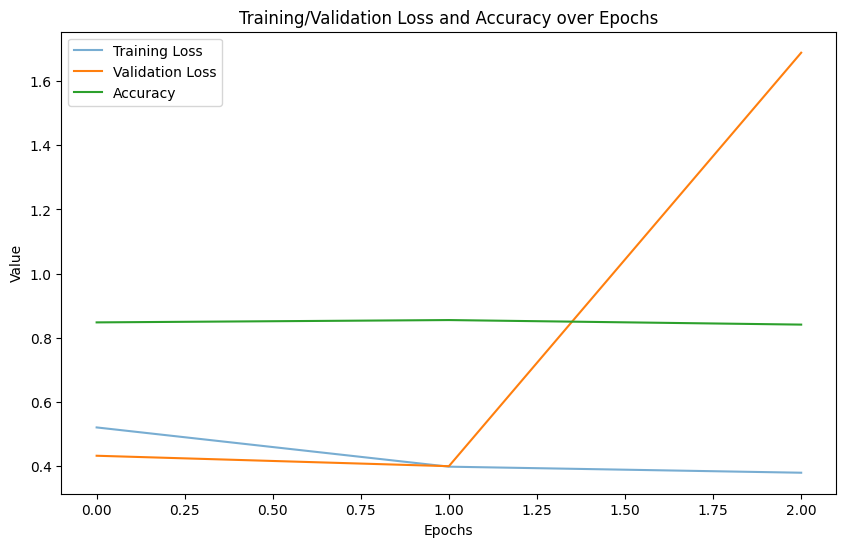

In [99]:
dls = to.dataloaders(bs=32)
learn = tabular_learner(dls, metrics=[accuracy, precision, recall])
learn.fit(3, lr=0.05)
plot_metrics(learn)

epoch,train_loss,valid_loss,accuracy,time
0,0.526501,1.385077,0.670466,00:07
1,0.377042,0.399772,0.861140,00:06
2,0.342333,0.363435,0.867012,00:07


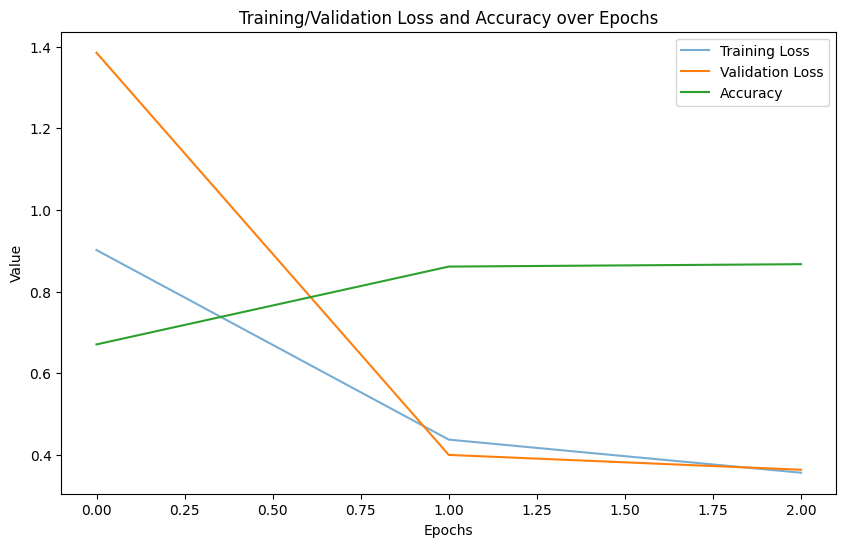

In [100]:
dls = to.dataloaders(bs=256)
learn = tabular_learner(dls, metrics=[accuracy])
learn.fit(3, lr=0.05)
plot_metrics(learn)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,1.322734,44.215294,0.107772,0.011790,0.107772,00:04
1,0.935629,73.166077,0.108463,0.014752,0.108463,00:01
2,0.763030,33.993076,0.251468,0.085706,0.251468,00:01


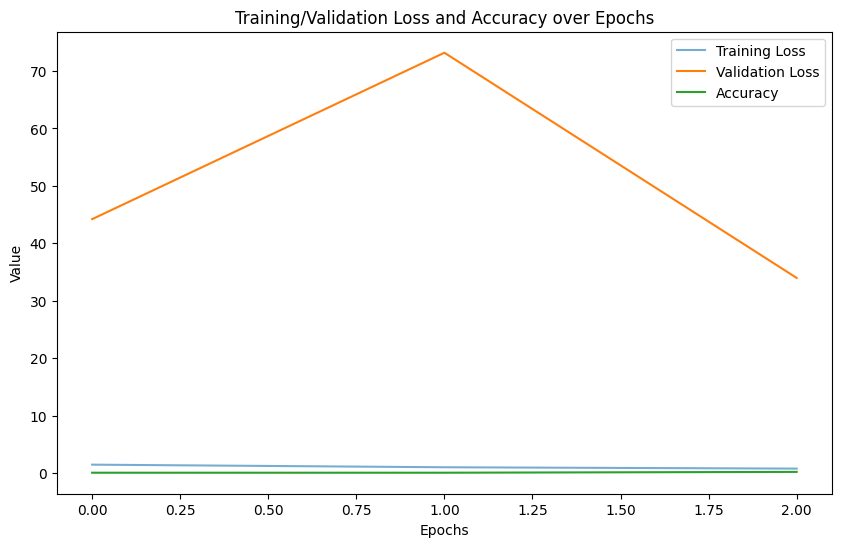

In [101]:
dls = to.dataloaders(bs=2056)
learn = tabular_learner(dls, metrics=[accuracy, precision, recall])
learn.fit(3, lr=0.05)
plot_metrics(learn)

The larger batch size meant that the model weights underwent fewer rounds of revision, so after 3 epochs, the performance was still poor. But if we increase the number of epochs, performance picks up again:

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,1.412328,69.192627,0.107772,0.011618,0.107772,00:01
1,1.029406,66.958908,0.107772,0.011618,0.107772,00:01
2,0.840511,45.177753,0.107772,0.011618,0.107772,00:01
3,0.713851,18.280130,0.115717,0.520174,0.115717,00:02
4,0.631071,8.300099,0.292919,0.680391,0.292919,00:02
5,0.575377,4.106793,0.494991,0.744282,0.494991,00:01
6,0.534267,1.411934,0.712953,0.848113,0.712953,00:01
7,0.498922,0.728409,0.793782,0.827694,0.793782,00:01
8,0.471616,0.506863,0.821416,0.823320,0.821416,00:01
9,0.447862,0.396438,0.850432,0.844691,0.850432,00:01


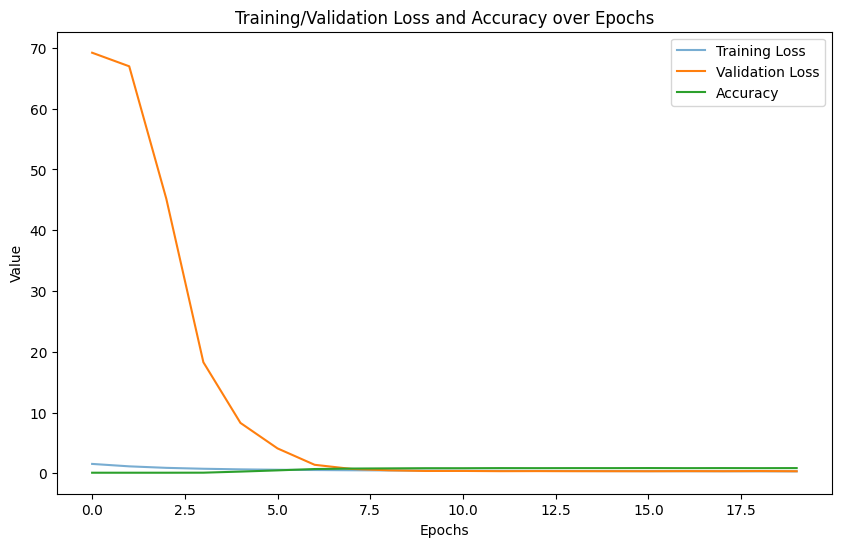

In [102]:
dls = to.dataloaders(bs=2056)
learn = tabular_learner(dls, metrics=[accuracy, precision, recall])
learn.fit(20, lr=0.05)
plot_metrics(learn)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.781243,53.990944,0.138169,0.224413,0.138169,00:07
1,0.555327,8.795654,0.302245,0.792411,0.302245,00:09
2,0.470048,1.587320,0.664594,0.780841,0.664594,00:07


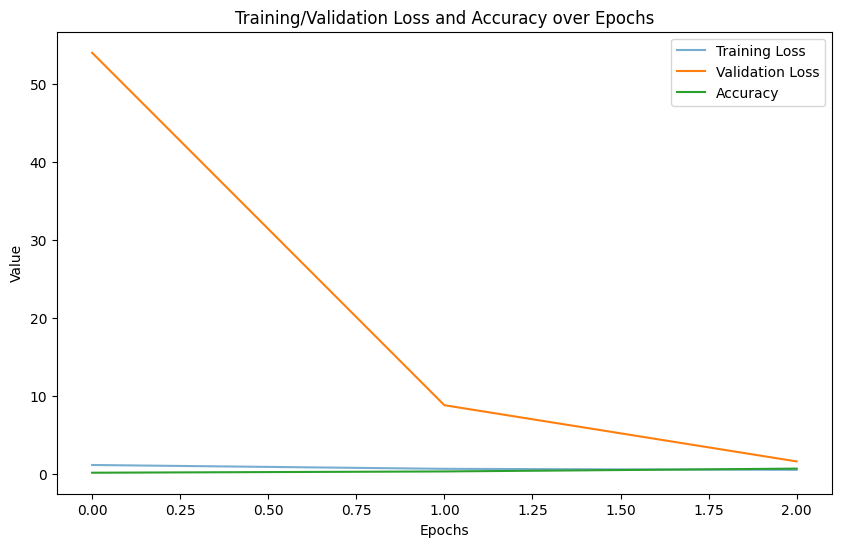

In [103]:
dls = to.dataloaders(bs=1028)
learn = tabular_learner(dls, metrics=[accuracy, precision, recall])
learn.fit(3, lr=0.05)
plot_metrics(learn)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,1.648612,1.665414,0.147841,0.021857,0.147841,00:09
1,1.528961,2.813112,0.157513,0.156584,0.157513,00:02
2,1.402004,2.696393,0.568567,0.484900,0.568566,00:04
3,1.314121,11.876380,0.508463,0.258534,0.508463,00:02
4,1.194339,24.966793,0.508463,0.258534,0.508463,00:06
5,1.098911,39.654541,0.508463,0.258534,0.508463,00:03
6,1.027822,51.948196,0.508463,0.258534,0.508463,00:03
7,0.963701,58.482841,0.508463,0.258534,0.508463,00:03
8,0.907440,58.042332,0.508463,0.258534,0.508463,00:02
9,0.858117,53.597786,0.508463,0.258534,0.508463,00:02


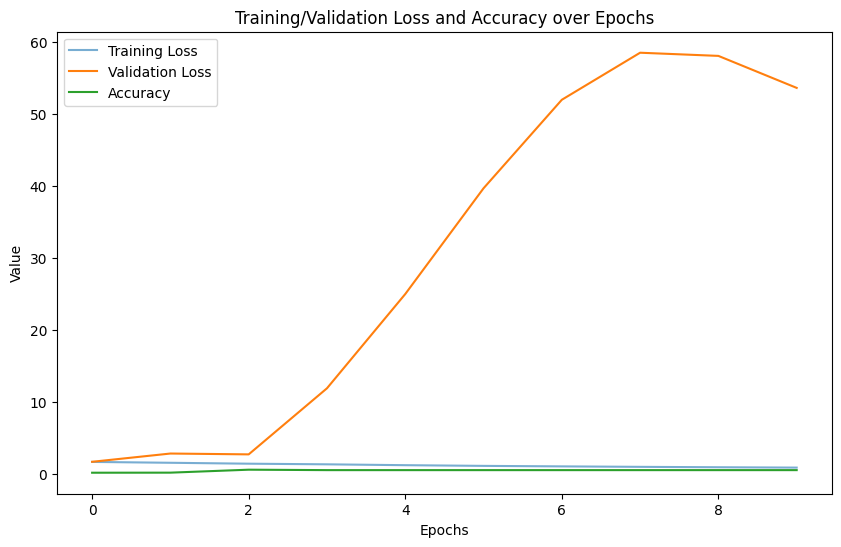

In [104]:
dls = to.dataloaders(bs=8224)
learn = tabular_learner(dls, metrics=[accuracy, precision, recall])
learn.fit(10, lr=0.05)
plot_metrics(learn)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,1.492338,1.389947,0.147841,0.021857,0.147841,00:04
1,1.449476,1.399310,0.147841,0.021857,0.147841,00:03
2,1.400872,1.408293,0.147841,0.021857,0.147841,00:02
3,1.348757,1.416471,0.147841,0.021857,0.147841,00:01
4,1.291755,1.423797,0.147841,0.021857,0.147841,00:01
5,1.241323,1.430110,0.147841,0.021857,0.147841,00:02
6,1.196679,1.435823,0.147841,0.021857,0.147841,00:01
7,1.154273,1.441477,0.147841,0.021857,0.147841,00:01
8,1.115055,1.447556,0.147841,0.021857,0.147841,00:01
9,1.074742,1.453997,0.147841,0.021857,0.147841,00:01


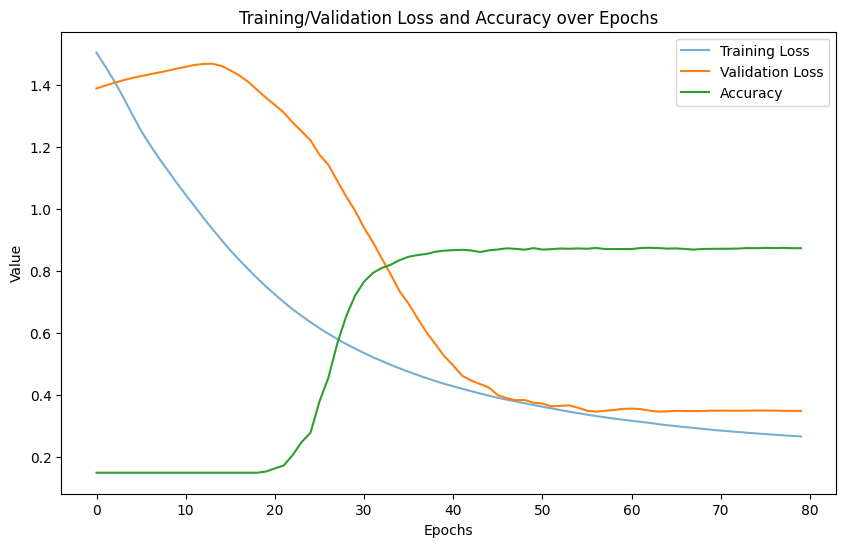

In [105]:
dls = to.dataloaders(bs=4112)
learn = tabular_learner(dls, metrics=[accuracy, precision, recall])
learn.fit_one_cycle(80)
plot_metrics(learn)

## Tweaking the learning rate

When we do a forward pass through the neural net, we initially feed an input to the neural net (a large numerical matrix) to output a set of numbers that consitute the prediction the model makes (in this case the probability that the input data has of siginfying each one of the output classes). We start with our weights initialised randomly, so the very first prediction is completely random. We then have a loss function that calculates how far the prediction was from the truth and calculate how different the weights would have needed to be and in which direction so we can update them to make a better prediction the next time.

Correcting these weights too fast gives wildly inaccurate results and correcting these weights too slowly means the model doesn't train fast enough and increased the risk of converging on a local minima. 

So we set a learning rate that is appropriate to the specifci dataset. In our library we have function lr_find which can help us find a good learning rate. A good rule of thumb is to pick a learning rate that is somewhere between this "valley" and "slide". Basically you want to pick a learning rate from the space where the loss is going down, before it starts going up again.

/home/carljvh/mambaforge/envs/ahri_env/lib/python3.12/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location

SuggestedLRs(valley=0.0006918309954926372, slide=0.007585775572806597)

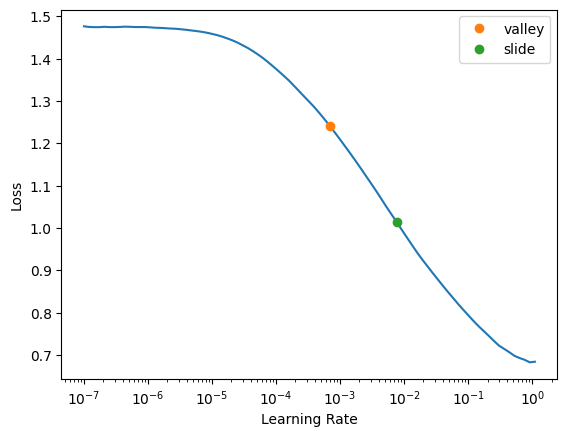

In [106]:
learn = tabular_learner(dls, metrics=[accuracy, precision, recall])
learn.lr_find(suggest_funcs=[valley, slide])

In [107]:
dls = to.dataloaders(bs=256)
learn = tabular_learner(dls, metrics=[accuracy, precision, recall]
learn.fit(3, lr=0.05)
plot_metrics(learn)

SyntaxError: '(' was never closed (3117234779.py, line 2)

That seems to work pretty well, now we will pick some bad learning rates to see what happens.

In [36]:
learn = tabular_learner(dls, metrics=[accuracy, precision, recall])
learn.fit(3, lr=0.00001)
plot_metrics(learn)

epoch,train_loss,valid_loss,accuracy,time
0,1.029432,1.053477,0.695337,00:05
1,0.889345,0.826392,0.734370,00:05
2,0.776109,0.733789,0.768566,00:05


In [ ]:
learn = tabular_learner(dls, metrics=[accuracy, precision, recall])
learn.fit(10, lr=0.00001)
plot_metrics(learn)

In [37]:
learn = tabular_learner(dls, metrics=[accuracy, precision, recall])
learn.fit(3, lr=1)
plot_metrics(learn)

epoch,train_loss,valid_loss,accuracy,time
0,3.922423,4.765784,0.607945,00:09
1,0.960552,0.927695,0.673230,00:05
2,0.489777,281.381622,0.640415,00:05


## Using a different training regime type that increases and decreases the learning rate

The fit_one_cycle() method uses something called *"Super-convergence"* where you start with a very large learning rate, then rapidly reduce the learning rate with the idea of training a model significantly faster. The technique is described in [the paper on Super-Convergence](https://arxiv.org/abs/1708.07120)

In [60]:
dls = to.dataloaders(bs=512)
learn = tabular_learner(dls, metrics=[accuracy, precision, recall])
learn.fit_one_cycle(20)
plot_metrics(learn)

epoch,train_loss,valid_loss,accuracy,time
0,1.251147,1.441776,0.147841,00:06
1,0.962627,1.352118,0.148532,00:04
2,0.732400,0.904696,0.792746,00:04
3,0.571535,0.449857,0.863903,00:04
4,0.469033,0.360799,0.863212,00:04
5,0.404960,0.383784,0.867703,00:03
6,0.358355,0.355027,0.874266,00:03
7,0.327336,0.348951,0.872539,00:04
8,0.302909,0.363725,0.868739,00:03
9,0.285913,0.361190,0.872193,00:03


This is what happens under the hood when we use fit_one_cycle, which changes the learning rate rather than keeping it fixed:

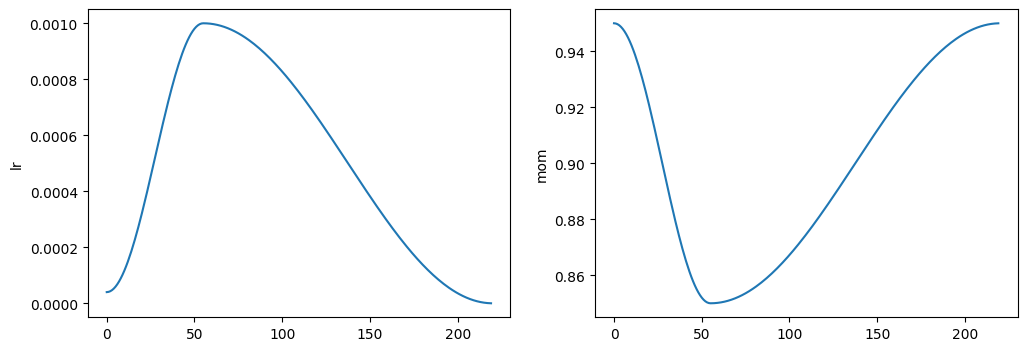

In [21]:
learn.recorder.plot_sched()

## Setting a large number of epochs and allowing the model to stop early

In [68]:
dls = to.dataloaders(bs=1028)

learn = tabular_learner(
    dls, 
    metrics=[accuracy, precision, recall],
    cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5, min_delta=0.001)]
)

# Train the model with early stopping
learn.fit_one_cycle(100)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,1.373260,1.448633,0.107772,0.011624,0.107772,00:03
1,1.241201,1.513269,0.107772,0.011624,0.107772,00:03
2,1.133639,1.568368,0.107772,0.011624,0.107772,00:03
3,1.041598,1.607210,0.292919,0.114981,0.292919,00:03
4,0.962355,1.572878,0.293955,0.208277,0.293955,00:03
5,0.888150,1.391405,0.316408,0.357128,0.316408,00:03
6,0.813532,1.097731,0.675993,0.780722,0.675993,00:03
7,0.743303,0.731862,0.825907,0.836140,0.825907,00:03
8,0.681149,0.510766,0.854231,0.853554,0.854231,00:03
9,0.618028,0.422670,0.860794,0.856843,0.860794,00:05


No improvement since epoch 18: early stopping


## Overfitting the model

In [66]:
dls = to.dataloaders(bs=1028)
learn = tabular_learner(dls, metrics=[accuracy, precision, recall])
learn.fit_one_cycle(100)
plot_metrics(learn)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,1.338345,1.376557,0.235924,0.055971,0.235924,00:04
1,1.185885,1.375229,0.235924,0.055971,0.235924,00:03
2,1.075161,1.394857,0.235924,0.055971,0.235924,00:02
3,0.980326,1.393233,0.235924,0.055971,0.235924,00:03
4,0.896863,1.304294,0.272193,0.160164,0.272193,00:02
5,0.825641,1.138691,0.525043,0.771821,0.525043,00:03
6,0.757974,0.898092,0.769603,0.794722,0.769603,00:03
7,0.692035,0.656080,0.823834,0.826131,0.823834,00:02
8,0.629702,0.492644,0.853541,0.850205,0.853541,00:02
9,0.578490,0.419114,0.865976,0.862208,0.865976,00:02


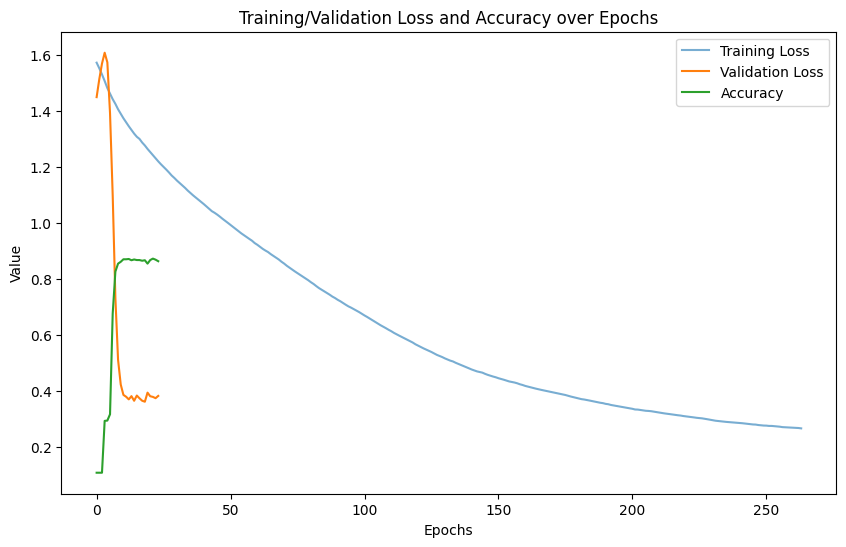

## Underfitting the model

In [25]:
dls = to.dataloaders(bs=1028)
learn = tabular_learner(dls, metrics=[accuracy, precision, recall])
learn.fit_one_cycle(2)
plot_metrics(learn)

epoch,train_loss,valid_loss,accuracy,time
0,1.003820,1.371606,0.107772,00:01
1,0.763799,1.396830,0.117444,00:01


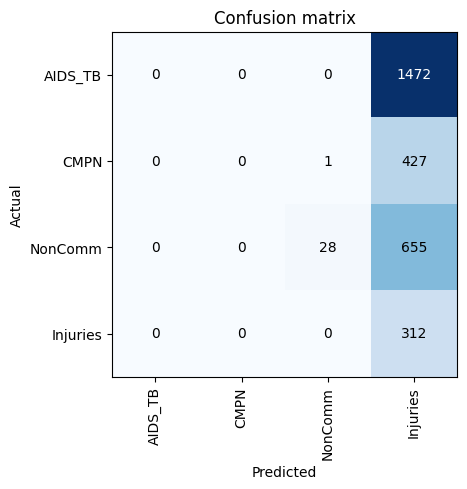

In [26]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# Final training run before we use the model to make predictions

In [61]:
dls = to.dataloaders(bs=512)

learn = tabular_learner(
    dls, 
    metrics=[accuracy, precision, recall],
    cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5, min_delta=0.001)]
)

# Train the model with early stopping
learn.fit_one_cycle(100)
plot_metrics(learn)

epoch,train_loss,valid_loss,accuracy,time
0,1.258064,1.463757,0.147841,00:04
1,1.082141,1.466659,0.159585,00:04
2,0.958162,1.277414,0.344041,00:04
3,0.845150,0.890754,0.758549,00:03
4,0.741262,0.591638,0.820725,00:03
5,0.648309,0.484405,0.850432,00:03
6,0.561753,0.434943,0.857686,00:03
7,0.490367,0.386693,0.868048,00:03
8,0.435699,0.367083,0.868739,00:04
9,0.391067,0.365987,0.868394,00:04


No improvement since epoch 14: early stopping


# Looking under the hood at our model

In [27]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(4, 3)
    (1-41): 41 x Embedding(3, 3)
    (42): Embedding(2, 2)
    (43): Embedding(3, 3)
    (44): Embedding(1, 2)
    (45-59): 15 x Embedding(3, 3)
    (60): Embedding(2, 2)
    (61-104): 44 x Embedding(3, 3)
    (105-106): 2 x Embedding(2, 2)
    (107-110): 4 x Embedding(3, 3)
    (111): Embedding(1, 2)
    (112-130): 19 x Embedding(3, 3)
    (131): Embedding(1, 2)
    (132-144): 13 x Embedding(3, 3)
    (145): Embedding(2, 2)
    (146-161): 16 x Embedding(3, 3)
    (162): Embedding(2, 2)
    (163-166): 4 x Embedding(3, 3)
    (167): Embedding(2, 2)
    (168-172): 5 x Embedding(3, 3)
    (173): Embedding(2, 2)
    (174-202): 29 x Embedding(3, 3)
    (203): Embedding(1, 2)
    (204-217): 14 x Embedding(3, 3)
    (218): Embedding(2, 2)
    (219-220): 2 x Embedding(3, 3)
    (221-223): 3 x Embedding(2, 2)
    (224): Embedding(3, 3)
    (225-226): 2 x Embedding(2, 2)
    (227): Embedding(3, 3)
    (228): Embedding(2, 2)
    (229)

Above is the standard architecture for FastAI TabularLearners, there are several notable ideas here:
* This model does not make use of one hot encoding for the categorical variables. See [this paper](https://arxiv.org/abs/1604.06737) for detail on how **"entity embeddings"** work. Basically categorical variables are mapped closer to each other in Euclidean spaces so specific relationships between objects in the category can be captured. This also saves memory and improves speed. This was combined with converting the variables to truly continuous variables see [this paper by the Google Play recommendation team](https://arxiv.org/abs/1606.07792)
* The first **normalisation layer** converts continuous variables to have a mean of 0 and deviation of 1 unit
* Use is made of **dropout**: this is a regularisation technique where a randomly selected fraction of the inputs are set to 0. This prevents overdependence and overfitting as the model cannot rely on any one feature. 
* Note that the humbe **ReLU** function is used in several layers here. This introduces non-linearity to the model and is part of what makes this model "deep learning" proper

# Interpreting results

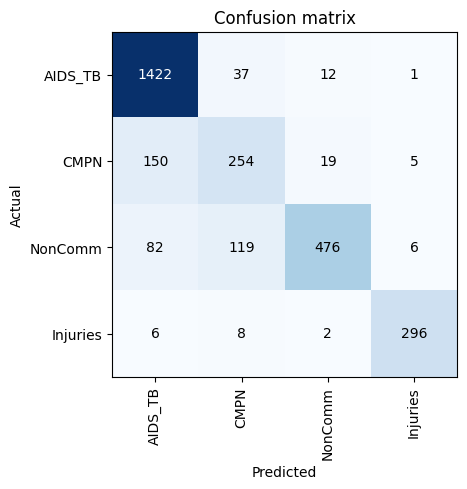

In [53]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# Making predictions on our unknown dataframe

In [55]:
# Drop the 'DeathCauseGBDgroup' column from df_unknown_gbd
df_unknown_gbd = df_unknown_gbd.drop(columns=['DeathCauseGBDgroup'])

# Convert df_unknown_gbd to TabularPandas, using the same processing as the training data
to_test = dls.test_dl(df_unknown_gbd)

# Make predictions using the learn object
predictions, probabilities = learn.get_preds(dl=to_test)

# Convert the predictions and probabilities to a human-readable format
predicted_classes = [dls.vocab[pred] for pred in predictions.argmax(dim=1)]

# Add predictions to the original dataframe
df_unknown_gbd['predicted_class'] = predicted_classes

# Optionally, add the probabilities to the dataframe as well
# df_unknown_gbd['probabilities'] = probabilities.tolist()

# Show the dataframe with predictions
df_unknown_gbd.head()

,ID,DateOfDeath,IEndInformantId,IEndInformantType,DateOfBirth,Sex,DeathNotificationDate,VisitType,DeathSetting_x,DeathCareProvider,...,i452o,i453o,i454o,i455o,i456o,i457o,i458o,i459o,Age,predicted_class
2,16,2013-01-18,25.0,Household Member,1952-11-16,Female,2013-02-19,Regular Visit,Own Home,Family Member,...,NaN,NaN,NaN,No,NaN,No,NaN,NaN,60.172485,NonComm
3,19,2015-10-14,34.0,Household Member,1939-08-18,Female,2015-11-17,Regular Visit,Own Home,Family Member,...,NaN,NaN,NaN,No,NaN,No,NaN,NaN,76.156057,NonComm
5,56,2013-08-03,NaN,Household Head,1953-04-16,Male,2013-11-12,Regular Visit,Governmental (public) Hospital,Nurse / Midwife,...,NaN,NaN,NaN,No,NaN,No,NaN,NaN,60.298426,NonComm
12,84,2016-08-27,83.0,Household Member,1983-12-03,Male,2016-11-02,Regular Visit,Governmental (public) Hospital,Nurse / Midwife,...,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,32.733744,AIDS_TB
24,135,2018-05-18,140.0,Household Member,1965-10-23,Male,2018-06-05,Regular Visit,Private Hospital,Nurse / Midwife,...,No,No,No,No,No,No,Yes,Yes,52.566735,NonComm


In [56]:
print(predictions)
print(predictions.shape)

tensor([[8.3976e-04, 1.4081e-02, 9.7159e-01, 1.3491e-02],
        [1.4282e-03, 2.9273e-02, 9.6554e-01, 3.7632e-03],
        [1.7660e-04, 7.1759e-03, 9.8906e-01, 3.5854e-03],
        ...,
        [2.1423e-03, 9.0657e-01, 9.0448e-02, 8.3509e-04],
        [3.1470e-01, 6.8292e-01, 1.3086e-03, 1.0652e-03],
        [5.1606e-03, 9.9418e-01, 5.1692e-04, 1.4726e-04]])
torch.Size([7217, 4])


# Comparing with a different model - XGBoost

In [59]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Extract training and validation data from the TabularPandas object
X_train, y_train = to.train.xs, to.train.y
X_valid, y_valid = to.valid.xs, to.valid.y

# Train the XGBoost model
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)

# Fit the model to the training data
xgb_model.fit(X_train, y_train)

# Make predictions on both training and validation sets
y_train_pred = xgb_model.predict(X_train)
y_valid_pred = xgb_model.predict(X_valid)

# Evaluate the model on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
train_f1 = f1_score(y_train, y_train_pred, average='weighted')

# Evaluate the model on the validation set
valid_accuracy = accuracy_score(y_valid, y_valid_pred)
valid_precision = precision_score(y_valid, y_valid_pred, average='weighted')
valid_recall = recall_score(y_valid, y_valid_pred, average='weighted')
valid_f1 = f1_score(y_valid, y_valid_pred, average='weighted')

# Print metrics for training set
print(f"Training Set Metrics:")
print(f"Accuracy: {train_accuracy}")
print(f"Precision: {train_precision}")
print(f"Recall: {train_recall}")
print(f"F1 Score: {train_f1}")

# Print metrics for validation set
print(f"\nValidation Set Metrics:")
print(f"Accuracy: {valid_accuracy}")
print(f"Precision: {valid_precision}")
print(f"Recall: {valid_recall}")
print(f"F1 Score: {valid_f1}")

# Print confusion matrix for validation set
print("\nConfusion Matrix for Validation Set:")
print(confusion_matrix(y_valid, y_valid_pred))

Training Set Metrics:
Accuracy: 0.9375647668393783
Precision: 0.9371391239407867
Recall: 0.9375647668393783
F1 Score: 0.9372781174954046

Validation Set Metrics:
Accuracy: 0.8721934369602763
Precision: 0.8705397955845516
Recall: 0.8721934369602763
F1 Score: 0.8712720698675451

Confusion Matrix for Validation Set:
[[1362   84   25    1]
 [  86  275   61    6]
 [  45   40  592    6]
 [   3    8    5  296]]
